<a href="https://colab.research.google.com/github/ShadyH20/NLP-project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [19]:
!pip install farasa
!pip install farasapy
!pip install arabic-reshaper
!pip install python-bidi
!pip install qalsadi
!pip install langdetect
!pip install googletrans
!pip install wordcloud


In [14]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from bidi.algorithm import get_display
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/shady/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shady/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shady/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shady/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shady/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shady/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/shady/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Unlabeled Data (Da7ee7, Elsaha)

In [15]:
BASE_DIR = "./YoutubeChannels"
CHANNELS = ["Da7ee7", "Elsaha"]
data = []

timestamp_pattern = re.compile(r"^\d+\.\d+:\s*")  # Removes timestamps at start of lines

for channel in CHANNELS:
    raw_data_path = os.path.join(BASE_DIR, channel, "Raw Data")
    
    if os.path.exists(raw_data_path):
        for file_name in os.listdir(raw_data_path):
            if file_name.endswith(".txt"):
                file_path = os.path.join(raw_data_path, file_name)
                
                with open(file_path, "r", encoding="utf-8") as f:
                    raw_lines = f.readlines()
                
                # Remove timestamps and extra whitespace from lines
                cleaned_text = "\n".join(re.sub(timestamp_pattern, "", line).strip() for line in raw_lines)
                episode_title = file_name.replace(".txt", "").strip()
                
                # Append the entire script as one row
                data.append([channel, episode_title, cleaned_text, "", ""])

# Create DataFrame
unlabelled_df = pd.DataFrame(data, columns=["Channel", "Episode Title", "Original Script", "Processed Script", "Category"])

### Labeled Data

In [16]:
BASE_DIR = "./YoutubeChannels"
LABELLED_CHANNELS_1 = ["Kefaya Ba2a", "Business Bel Araby", "B Hodoo2"]
LABELLED_CHANNELS_2 = ["Eqtisad_Al_Hadaraa",
                       "Fi_Al_Hadaraa", "Al_Mokhbir_Al_Eqtisadi"]
LABELLED_CHANNELS_3 = ["Akhdar"]
data = []


def process_labelled_channel_1(channel):
    raw_data_path = os.path.join(BASE_DIR, channel, "raw")
    annotations_path = os.path.join(BASE_DIR, channel, "annotations.json")

    if os.path.exists(annotations_path):
        with open(annotations_path, "r", encoding="utf-8") as f:
            annotations = json.load(f)

        metadata_map = {
            item["title"].strip()[:10] if channel != "Kefaya Ba2a" else item["title"].strip(): item
            for item in annotations
        }

        if os.path.exists(raw_data_path):
            for file_name in os.listdir(raw_data_path):
                if file_name.endswith(".txt"):
                    file_path = os.path.join(raw_data_path, file_name)
                    with open(file_path, "r", encoding="utf-8") as f:
                        raw_text = f.read().strip()

                    episode_title = file_name.replace(".txt", "").strip()
                    match_key = episode_title[:10] if channel != "Kefaya Ba2a" else episode_title
                    metadata = metadata_map.get(match_key, {})

                    data.append([
                        channel,
                        episode_title,
                        raw_text,
                        "",
                        metadata.get("dialogue", ""),
                        metadata.get("type", ""),
                        metadata.get("length", ""),
                        metadata.get("category", "")
                    ])


def process_labelled_channel_2(channel):
    raw_data_path = os.path.join(BASE_DIR, channel, "raw_data")
    metadata_path = os.path.join(BASE_DIR, channel, "metadata")

    if os.path.exists(raw_data_path) and os.path.exists(metadata_path):
        for file_name in os.listdir(raw_data_path):
            if file_name.endswith(".txt"):
                episode_title = file_name.replace(".txt", "").strip()
                raw_file_path = os.path.join(raw_data_path, file_name)
                metadata_file_path = os.path.join(
                    metadata_path, episode_title + ".json")

                with open(raw_file_path, "r", encoding="utf-8") as f:
                    raw_text = f.read().strip()

                if os.path.exists(metadata_file_path):
                    with open(metadata_file_path, "r", encoding="utf-8") as f:
                        metadata = json.load(f)
                    category = metadata.get("categories", [""])[0]

                    data.append([
                        channel,
                        episode_title,
                        raw_text,
                        "",
                        metadata.get("dialogue", ""),
                        metadata.get("type", ""),
                        metadata.get("length", ""),
                        category
                    ])


def find_akhdar_raw_and_metadata(path):
    for root, dirs, files in os.walk(path):
        if "raw_data" in dirs and "metadata" in dirs:
            process_labelled_channel_2(root)


def process_labelled_channel_3(channel):
    base_path = os.path.join(BASE_DIR, channel)
    find_akhdar_raw_and_metadata(base_path)


# Process all channels
for channel in LABELLED_CHANNELS_1:
    process_labelled_channel_1(channel)

for channel in LABELLED_CHANNELS_2:
    process_labelled_channel_2(channel)

for channel in LABELLED_CHANNELS_3:
    process_labelled_channel_3(channel)

labelled_df = pd.DataFrame(data, columns=[
                           "Channel", "Episode Title", "Original Script", "Processed Script", "Dialogue", "Type", "Length", "Category"])

### Data Loading Results

In [17]:
def sample_rows_per_channel(df, channel_column="Channel", num_samples=3):
    unique_channels = df[channel_column].unique()
    for channel in unique_channels:
        print(f"📌 Sample rows from channel: {channel}")
        display(df[df[channel_column] == channel].sample(min(num_samples, len(df[df[channel_column] == channel]))))
        print("-" * 80)

print("📍 Checking Unlabelled DataFrame:")
sample_rows_per_channel(unlabelled_df)

print("\n📍 Checking Labelled DataFrame:")
sample_rows_per_channel(labelled_df)


📍 Checking Unlabelled DataFrame:
📌 Sample rows from channel: Da7ee7


,Channel,Episode Title,Original Script,Processed Script,Category
10,Da7ee7,أخطر رجل مافيا الدحيح,[موسيقى]\n[موسيقى]\nاسمع يا ابني تطلع على مزرع...,,
57,Da7ee7,بيتهوفن الدحيح,"هو ""بيتهوفن"" اتأخر كدا ليه؟!\nمش عوايده يعني!\...",,
130,Da7ee7,غاز سام نتنفسه يوميًا الدحيح,يا يا محمود مش مصدقه ان جوزي مدرب غطص قد\nالدن...,,


--------------------------------------------------------------------------------
📌 Sample rows from channel: Elsaha


,Channel,Episode Title,Original Script,Processed Script,Category
163,Elsaha,أقوى من الخوف والإعاقة.. حكاية عبد الرحمن صلاح,[موسيقى]\nاول ما لبست الطرف طبعا كان مضايقني ب...,,
162,Elsaha,طلاب فلسطينيون في مصر.. حكاية إسماعيل غيث,يوم ارجع غزه يوم\nالمنى طبعا اول شي ارجع\nواعز...,,
166,Elsaha,كسر عزلة التوحد.. حكاية رانيا وحمزة,انا بعتبر نفسي ام الطفلين كل واحد فيهم\nمختلف ...,,


--------------------------------------------------------------------------------

📍 Checking Labelled DataFrame:
📌 Sample rows from channel: Kefaya Ba2a


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
17,Kefaya Ba2a,كفاية بقى بودكاست - الحصة التانية,اهلا بكم في بودكاست كفايه بقى البودكاست\nده يا...,,false,Podcast,,People & Blogs
4,Kefaya Ba2a,بودكاست كفاية بقى - سوبر سوبريم,[موسيقى]\nاهلا بكم في بودكاست كفايه بقى البودك...,,false,Podcast,,Comedy
9,Kefaya Ba2a,بودكاست كفاية بقى - في الجسم السليم,[موسيقى]\nاهلا بكم في بودكاست كفايه بقى البودك...,,false,Podcast,,Comedy


--------------------------------------------------------------------------------
📌 Sample rows from channel: Business Bel Araby


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
23,Business Bel Araby,من مهندس الى رئيس مجلس ادارة لشركة مقاولات - ...,اوحش حاجه تعملها لنفسك ان انت وانت نازل\nالشغل...,,true,Podcast,,People & Blogs
21,Business Bel Araby,اسرا البيع الاونلاين وكيفية بناء براند قوي - م...,ودائما الناس بتستنى الوقت المثالي عشان\nتبدا ي...,,true,Podcast,,People & Blogs
22,Business Bel Araby,ما معنى النجاح #2,ايه معنى النجاح بالنسبه لك في الحياه\nعامه عار...,,true,Podcast,,Education


--------------------------------------------------------------------------------
📌 Sample rows from channel: B Hodoo2


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
41,B Hodoo2,٩ نصائح للصحة النفسية غيرت حياتي - الجزء الأ...,السلام عليكم ورحمه الله وبركاته دي نصائح\nالتل...,,,,,
28,B Hodoo2,أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بود...,النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...,,,,,
30,B Hodoo2,لا تدمر صحتك النفسية! الجزء الثاني من ٩ نصائ...,اهلا وسهلا بكم في الجزء التاني من تسع\nنصائح ن...,,false,Podcast,,Education


--------------------------------------------------------------------------------
📌 Sample rows from channel: Fi_Al_Hadaraa


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
58,Fi_Al_Hadaraa,المحسوبية_هتودينا_فين_صديقي_الإنسان__في_الحضارة,"يا عم ""شلبي""، كفاية مقدّمات بقى!\nطب بأقولّك إ...",,,Youtube,00:17:40,Entertainment
87,Fi_Al_Hadaraa,مافيش_مستحيل_.._دليلك_للنجاح_والشهرة_والاكتئا...,حاضر، حاضر!\nما قلنا حاضر!\nإيه يا ست الكل؟ خي...,,,Youtube,00:13:01,People & Blogs
61,Fi_Al_Hadaraa,أوهام_السعادة__في_الحضارة,"يعني إيه تبطّل يا ""سعدني""؟! قصدك إيه؟!\nأسوأ ع...",,,Youtube,00:31:01,People & Blogs


--------------------------------------------------------------------------------
📌 Sample rows from channel: Al_Mokhbir_Al_Eqtisadi


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
267,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي__ماذا_لو_دخلت_إسرائيل_في_حر...,في صباح يوم 11 اكتوبر 2023 كبار\nالمسؤولين في ...,,,Youtube,00:40:04,Entertainment
295,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي___لماذا_قد_ترتفع_الأسعار_بسر...,اللي ساعد الصين على الصعود لمكانتها\nالحاليه ك...,,,Youtube,00:18:05,Entertainment
208,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي__هل_تستطيع_أمريكا_حرمان_السع...,هل ممكن أمريكا تتهور وتعاقب\nالمملكة العربية ا...,,,Youtube,00:19:46,Entertainment


--------------------------------------------------------------------------------


# Analysis & Processing

### 2. Analysis on Original Script
	
	Channel Analysis:
	- avg length / duration of episodes per channel
	- modal categories per channel, Category / class imbalance
	- etc
	- metdata analysis
	- Text Charactertistics (formal / informal... dialogue?)
	
	NLP Analysis:
	- Text Sampling
	- Text Statistics (word count, sentence length...)

📍 Analysis for Labelled Data:
=== CHANNEL ANALYSIS ===

📌 Average Episode Length per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi    2521.040541
B Hodoo2                  3664.391304
Business Bel Araby        6335.666667
Fi_Al_Hadaraa             3376.677966
Kefaya Ba2a               4462.142857
Name: Script Length, dtype: float64

📌 Number of Episodes per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi    222
B Hodoo2                   23
Business Bel Araby          6
Fi_Al_Hadaraa              59
Kefaya Ba2a                21
Name: Episode Title, dtype: int64

📌 Most Common Category per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi     Entertainment
B Hodoo2                       Education
Business Bel Araby        People & Blogs
Fi_Al_Hadaraa             People & Blogs
Kefaya Ba2a               People & Blogs
Name: Category, dtype: object


/var/folders/lp/5_kw6sqs1fv345yzdd0q9jcc0000gn/T/ipykernel_82593/2549020960.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_distribution.index, y=category_distribution.values, palette="viridis")


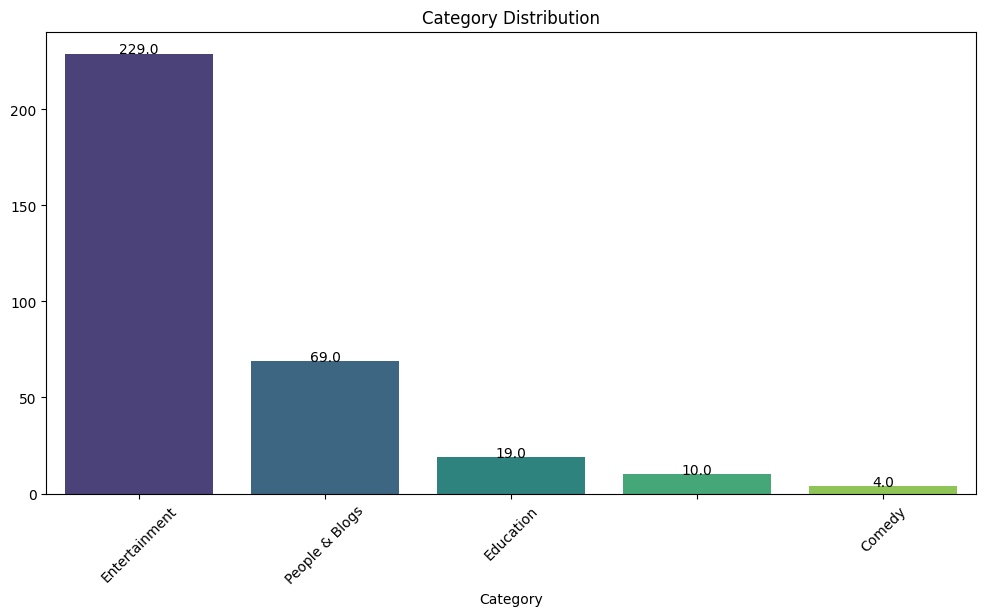

/var/folders/lp/5_kw6sqs1fv345yzdd0q9jcc0000gn/T/ipykernel_82593/2549020960.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dialogue_counts.index, y=dialogue_counts.values, palette="coolwarm")


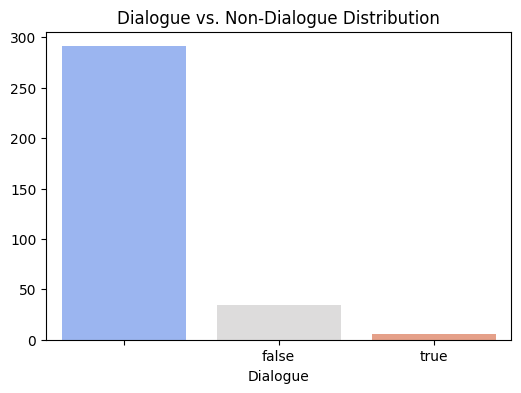


📍 NLP Analysis for Labelled Data:
=== NLP ANALYSIS ===

📌 Word Count Statistics:
 count     331.000000
mean     2945.302115
std      1154.268101
min        72.000000
25%      2171.500000
50%      2635.000000
75%      3416.500000
max      7996.000000
Name: Word Count, dtype: float64

📌 Lexical Diversity: 0.0984

📌 Percentage of Stopwords: 18.38 %

📌 Most Common Words:
 [('اللي', 17868), ('دي', 8738), ('ده', 7318), ('مش', 6464), ("''", 6283), ('ان', 5907), ('.', 5608), ('يعني', 4919), ('انا', 4597), ('انت', 4583)]

📌 Most Common Bigrams:
 [(("''", '،'), 1448), (('صديقي', 'الإنسان،'), 814), (('اللي', 'فات'), 572), (('[', 'موسيقى'), 563), (('موسيقى', ']'), 563), (('ان', 'انا'), 499), (('ان', 'انت'), 457), (('الـ', "''"), 427), (('اللي', 'كانت'), 413), (('النهار', 'دا'), 397)]

📌 Most Common Trigrams:
 [(('[', 'موسيقى', ']'), 563), (('الله', 'سبحانه', 'وتعالى'), 285), (('بقى', 'كفايه', 'بقى'), 141), (('جديده', 'باذن', 'الله'), 140), (('انا', 'اشرف', 'ابراهيم'), 137), (('حلقات', 'جديده', 'ب

In [18]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def arabic_tokenizer(text):
    return tokenize.word_tokenize(text)

# Combine Arabic + English stopwords
ALL_STOPWORDS = set(stopwords.words("arabic") + stopwords.words("english"))

def analyze_channel_data(labelled_df):
    print("=== CHANNEL ANALYSIS ===")

    df = labelled_df.copy()
    df = df.dropna(subset=["Category"])
    df["Script Length"] = df["Original Script"].apply(lambda x: len(arabic_tokenizer(x)))

    # Average Script length per channel
    avg_length = df.groupby("Channel")["Script Length"].mean()
    print("\n📌 Average Episode Length per Channel:\n", avg_length)

    # Number of episodes per channel
    episode_count = df.groupby("Channel")["Episode Title"].nunique()
    print("\n📌 Number of Episodes per Channel:\n", episode_count)

    # Most common category per channel
    modal_category = df.groupby("Channel")["Category"].agg(lambda x: x.value_counts().idxmax() if x.value_counts().size > 0 else "Unknown")
    print("\n📌 Most Common Category per Channel:\n", modal_category)

    # Plot category distribution
    plt.figure(figsize=(12, 6))
    category_distribution = df["Category"].value_counts()
    ax = sns.barplot(x=category_distribution.index, y=category_distribution.values, palette="viridis")
    plt.xticks(rotation=45)
    plt.title("Category Distribution")
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    plt.show()

    # Dialogue analysis
    if "Dialogue" in df.columns and df["Dialogue"].notna().sum() > 0:
        dialogue_counts = df["Dialogue"].dropna().value_counts()
        plt.figure(figsize=(6, 4))
        sns.barplot(x=dialogue_counts.index, y=dialogue_counts.values, palette="coolwarm")
        plt.title("Dialogue vs. Non-Dialogue Distribution")
        plt.show()

def analyze_nlp_statistics(labelled_df):
    print("=== NLP ANALYSIS ===")

    df = labelled_df.copy()
    df["Word Count"] = df["Original Script"].apply(lambda x: len(arabic_tokenizer(x)))
    print("\n📌 Word Count Statistics:\n", df["Word Count"].describe())

    # Lexical diversity
    all_words = [word.lower() for sentence in df["Original Script"] for word in arabic_tokenizer(sentence)]
    unique_words = set(all_words)
    lexical_diversity = len(unique_words) / len(all_words) if all_words else 0
    print("\n📌 Lexical Diversity:", round(lexical_diversity, 4))

    # Stopword ratio
    filtered_words = [word for word in all_words if word not in ALL_STOPWORDS]
    stopword_ratio = 1 - (len(filtered_words) / len(all_words)) if all_words else 0
    print("\n📌 Percentage of Stopwords:", round(stopword_ratio * 100, 2), "%")

    # Most common words
    common_words = Counter(filtered_words)
    print("\n📌 Most Common Words:\n", common_words.most_common(10))

    # Common bigrams and trigrams
    bigrams = list(ngrams(filtered_words, 2))
    trigrams = list(ngrams(filtered_words, 3))
    print("\n📌 Most Common Bigrams:\n", Counter(bigrams).most_common(10))
    print("\n📌 Most Common Trigrams:\n", Counter(trigrams).most_common(10))
    
print("📍 Analysis for Labelled Data:")
analyze_channel_data(labelled_df)

print("\n📍 NLP Analysis for Labelled Data:")
analyze_nlp_statistics(labelled_df)

# print("\n📍 Analysis for Unlabelled Data:")
# analyze_channel_data(unlabelled_df)

# print("\n📍 NLP Analysis for Unlabelled Data:")
# analyze_nlp_statistics(unlabelled_df)

Abbreviations Analysis

In [27]:
import re
from collections import Counter

def extract_abbreviations_per_channel(df, text_column="Original Script", channel_column="Channel"):
    # Match words with only capital letters, min length 2
    abbreviation_pattern = re.compile(r"\b[A-Z]{2,}\b")
    
    channel_abbreviation_stats = {}

    for channel, group in df.groupby(channel_column):
        all_abbreviations = []
        
        for text in group[text_column].dropna():
            abbreviations = abbreviation_pattern.findall(text)
            all_abbreviations.extend(abbreviations)
        
        abbreviation_counts = Counter(all_abbreviations)
        channel_abbreviation_stats[channel] = abbreviation_counts
    
    return channel_abbreviation_stats

# Run on both labelled and unlabelled datasets
print("=== Labelled Dataset ===")
labelled_abbreviations = extract_abbreviations_per_channel(labelled_df)
for channel, counts in labelled_abbreviations.items():
    print(f"\n📌 Channel: {channel}")
    print(f"Total Unique Abbreviations: {len(counts)}")
    print("Abbreviations & Counts:")
    for abbr, count in counts.items():
        print(f"{abbr}: {count} times")

print("\n=== Unlabelled Dataset ===")
unlabelled_abbreviations = extract_abbreviations_per_channel(unlabelled_df)
for channel, counts in unlabelled_abbreviations.items():
    print(f"\n📌 Channel: {channel}")
    print(f"Total Unique Abbreviations: {len(counts)}")
    print("Abbreviations & Counts:")
    for abbr, count in counts.items():
        print(f"{abbr}: {count} times")

=== Labelled Dataset ===

📌 Channel: Al_Mokhbir_Al_Eqtisadi
Total Unique Abbreviations: 91
Abbreviations & Counts:
CIA: 1 times
USAID: 1 times
FOMC: 5 times
IOS: 1 times
CFA: 22 times
SDECE: 1 times
GSM: 2 times
ETLA: 2 times
BASF: 1 times
ISO: 3 times
AEPR: 3 times
AK: 1 times
NNPC: 1 times
DGB: 1 times
AG: 3 times
GMBH: 1 times
FBI: 1 times
IQ: 2 times
FOMO: 1 times
SE: 1 times
SAMA: 1 times
SDR: 3 times
ARAMCO: 1 times
LNG: 1 times
BIS: 1 times
NUDT: 1 times
EDA: 4 times
ASML: 61 times
FDPR: 1 times
SMIC: 2 times
DRAM: 1 times
NAND: 2 times
CCD: 1 times
MH: 1 times
SES: 1 times
MSNBC: 1 times
ABS: 1 times
CEF: 1 times
AA: 1 times
OPC: 10 times
DUV: 6 times
EUV: 13 times
SK: 1 times
CFIUS: 3 times
DOI: 2 times
GIC: 3 times
ITRI: 1 times
TSMC: 5 times
CSET: 1 times
API: 2 times
KPMG: 1 times
CII: 1 times
BYD: 64 times
PHEV: 1 times
NA: 1 times
NBER: 1 times
FTX: 63 times
US: 2 times
BUSD: 1 times
FTT: 21 times
AIG: 1 times
CRP: 2 times
ATM: 1 times
CNC: 1 times
NDTV: 1 times
ERM: 2 ti

### 3. Preprocessing
	- Punctuation, Symbols, Numbers, Diactritics (tashkeel) removal
	- Stemming / lemmatization?
	- Normalization of Arabic letters
	- Code switching handling? Translation? What about abbreviations?

In [32]:
import qalsadi.lemmatizer
# from nltk.stem.arlstem2 import ARLSTem2Stemmer
# from nltk.stem.arlstem import ARLSTEMmer
from nltk.stem.isri import ISRIStemmer
# from camel_tools.utils.dediac import dediac_ar
# from camel_tools.morphology.reinflector import Reinflector
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.tokenizers.word import simple_word_tokenize
from nltk.tokenize import word_tokenize
import string
import re
import nltk
nltk.download('punkt')
nltk.download('punkt')

ARABIC_NORMALIZATION_MAP = str.maketrans({
    "أ": "ا",
    "إ": "ا",
    "آ": "ا",
    "ى": "ي",
    "ة": "ه",
})

ARABIC_PUNCTUATION = "؟،؛«»ـ…“”‘’–—"

ALL_PUNCTUATION = string.punctuation + ARABIC_PUNCTUATION

ARABIC_STOPWORDS = set(stopwords.words('arabic')) if 'arabic' in stopwords.fileids() else set([
    "في", "من", "على", "ما", "و", "لا", "عن", "إلى", "أن", "هو", "هي", "هذا", "ذلك", "كل", "كان", "كما",
    "لذلك", "أو", "أي", "لم", "قد", "أكثر", "أقل", "هنا", "هناك", "بعد", "قبل", "بين", "مع", "حتى", "إذا",
    "ثم", "لكن", "أحد", "أيضا", "أثناء", "عند", "أين", "كيف", "إلا", "أصبح", "لأن", "بسبب", "هذه", "هؤلاء",
    "التي", "الذي", "الذين", "اللذي", "اللذين", "اللائي"
])

EGYPTIAN_STOPWORDS = {
    "اللي", "دي", "ده", "اوعى", "أوي", "كده", "ليه", "وهم", "يلا", "عشان", "حاجه", "بتاع", "اه",
    "لأ", "تمام", "منين", "مش", "هو", "هي", "إحنا", "إنت", "أنا", "انت", "احنا", "هوه", "هم",
    "كلهم", "والله", "عايز", "مش", "عندك", "فين", "معايا", "لو", "قدام", "هعمل", "برضه",
    "ده", "مرة", "ممكن", "ماشي", "شوية", "شويه", "اعرف", "ازاي", "يلا", "لازم", "حاجة",
    "دحين", "تسأل", "عادي", "جديد", "دلوقتي", "دلوقتي", "خلص", "علشان", "حبيبي", "نقدر",
    "تعال", "طيب", "خلاص", "حوالي", "مع", "عند", "شويه", "يعني", "طبعا", "إزاي", "ايه",
    "ازاي", "معاك", "طب", "مين", "مين", "كويس", "عايز", "حبيبي"
}

STOPWORDS = ARABIC_STOPWORDS.union(EGYPTIAN_STOPWORDS)

ENGLISH_ABBREVIATIONS = {
    "CIA": "وكالة المخابرات المركزية",
    "USAID": "الوكالة الأمريكية للتنمية الدولية",
    "FOMC": "اللجنة الفيدرالية للسوق المفتوحة",
    "IOS": "نظام تشغيل آي أو إس",
    "CFA": "محلل مالي معتمد",
    "SDECE": "الخدمة السرية للدفاع الوطني",
    "GSM": "النظام العالمي للاتصالات المتنقلة",
    "ETLA": "الاتحاد الأوروبي للتكنولوجيا والتعليم",
    "BASF": "شركة الكيميائيات الألمانية",
    "ISO": "المنظمة الدولية للتوحيد القياسي",
    "AEPR": "التقييم السنوي للأداء الاقتصادي",
    "AK": "كلاشينكوف",
    "NNPC": "شركة البترول الوطنية النيجيرية",
    "DGB": "الإدارة العامة للأمن",
    "AG": "شركة ذات مسؤولية محدودة",
    "GMBH": "شركة محدودة المسؤولية في ألمانيا",
    "FBI": "مكتب التحقيقات الفيدرالي",
    "IQ": "معدل الذكاء",
    "FOMO": "الخوف من تفويت الفرصة",
    "SE": "هندسة البرمجيات",
    "SAMA": "مؤسسة النقد العربي السعودي",
    "SDR": "حقوق السحب الخاصة",
    "ARAMCO": "شركة أرامكو السعودية",
    "LNG": "الغاز الطبيعي المسال",
    "BIS": "بنك التسويات الدولية",
    "NUDT": "جامعة الدفاع الوطني للتكنولوجيا",
    "EDA": "إدارة التنمية الاقتصادية",
    "ASML": "شركة تكنولوجيا أشباه الموصلات",
    "FDPR": "لوائح المنتجات الأجنبية المباشرة",
    "SMIC": "شركة تصنيع أشباه الموصلات الصينية",
    "DRAM": "ذاكرة الوصول العشوائي الديناميكية",
    "NAND": "ذاكرة فلاش ناند",
    "CCD": "جهاز الشحن المزدوج",
    "MH": "ميغاهيرتز",
    "SES": "أنظمة الاتصالات الفضائية",
    "MSNBC": "قناة الأخبار الأمريكية",
    "ABS": "نظام الفرامل المانع للانغلاق",
    "CEF": "صندوق الصرف الأوروبي",
    "AA": "الخطوط الجوية الأمريكية",
    "OPC": "لجنة العمليات",
    "DUV": "الأشعة فوق البنفسجية العميقة",
    "EUV": "الأشعة فوق البنفسجية الشديدة",
    "CFIUS": "لجنة الاستثمار الأجنبي في الولايات المتحدة",
    "DOI": "وزارة الداخلية",
    "GIC": "شركة الاستثمار الحكومية",
    "ITRI": "معهد الأبحاث الصناعية",
    "TSMC": "شركة تصنيع أشباه الموصلات التايوانية",
    "API": "واجهة برمجة التطبيقات",
    "KPMG": "شركة التدقيق العالمية",
    "CII": "اتحاد الصناعات الهندية",
    "BYD": "شركة السيارات الكهربائية الصينية",
    "PHEV": "السيارات الكهربائية الهجينة",
    "NBER": "المكتب الوطني للبحوث الاقتصادية",
    "FTX": "منصة تداول العملات الرقمية",
    "US": "الولايات المتحدة",
    "BUSD": "عملة بينانس المستقرة",
    "FTT": "رمز FTX الأصلي",
    "AIG": "مجموعة التأمين الأمريكية",
    "CRP": "برنامج الحفظ الزراعي",
    "ATM": "الصراف الآلي",
    "CNC": "التحكم الرقمي بالكمبيوتر",
    "NDTV": "القناة الهندية الإخبارية",
    "ERM": "إدارة المخاطر المؤسسية",
    "YCC": "التحكم في منحنى العائد",
    "ENN": "شركة الطاقة الصينية",
    "ECO": "النظام البيئي",
    "SEC": "لجنة الأوراق المالية والبورصات",
    "CHIPS": "قانون دعم إنتاج أشباه الموصلات",
    "CCIEE": "المركز الصيني للتبادلات الاقتصادية الدولية",
    "WS": "وول ستريت",
    "MD": "المدير الطبي",
    "FAA": "إدارة الطيران الفيدرالية",
    "IATA": "الاتحاد الدولي للنقل الجوي",
    "MIT": "معهد ماساتشوستس للتكنولوجيا",
    "PACS": "نظام أرشفة الصور والاتصالات",
    "USB": "منفذ الناقل التسلسلي العالمي",
    "NASA": "وكالة الفضاء الأمريكية",
    "WWE": "المصارعة العالمية الترفيهية",
    "GPS": "نظام تحديد المواقع العالمي"
}


# Initialize Qalsadi lemmatizer
# TOOK TOO LONG
lemmatizer = qalsadi.lemmatizer.Lemmatizer()

isri_stemmer = ISRIStemmer()


def apply_stemmer(tokens, stemmer):
    start_time = time.time()
    stemmed = [stemmer.stem(token) for token in tokens]
    end_time = time.time()
    processing_time = end_time - start_time
    return stemmed, processing_time


# Initialize CAMeL Tools morphological analyzer for lemmatization
# Load the Standard Arabic morphological database
db = MorphologyDB.builtin_db()
analyzer = Analyzer(db)
mle_disambiguator = MLEDisambiguator.pretrained()


def camel_lemmatize(tokens):
    start_time = time.time()

    lemmas = []
    for token in tokens:
        # All possible analyses for the token
        analyses = analyzer.analyze(token)

        # Select the most likely analysis
        disambig = mle_disambiguator.disambiguate([token], [analyses])

        if disambig[0].analyses:
            # Top analysis
            top_analysis = disambig[0].analyses[0]
            if 'lex' in top_analysis.analysis:
                lemmas.append(top_analysis.analysis['lex'])
            else:
                lemmas.append(disambig[0].word)  # Fallback to original word
        else:
            lemmas.append(disambig[0].word)  # Fallback to original word

    end_time = time.time()
    processing_time = end_time - start_time
    return lemmas, processing_time


def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""

    text = text.replace("\n", " ")

    # Normalize Arabic letters
    text = text.translate(ARABIC_NORMALIZATION_MAP)

    # Replace English abbreviations
    words = text.split()
    replaced_words = []
    for word in words:
        if re.match(r"^[A-Z]{2,}$", word):
            word = ENGLISH_ABBREVIATIONS.get(word.upper(), word)
        replaced_words.append(word)
    text = " ".join(replaced_words)

    # Remove punctuation
    text = re.sub(f"[{re.escape(ALL_PUNCTUATION)}]", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [tok for tok in tokens if tok not in STOPWORDS]

    print("\nTokenized Text:")
    print(filtered_tokens[:20])

    # # Lemmatize Arabic words
    # lemmatized_tokens = [lemmatizer.lemmatize(tok) for tok in filtered_tokens]

    # Apply ISRI Arabic stemmer
    # isri_stems, isri_time = apply_stemmer(filtered_tokens, isri_stemmer)

    # Display stemming results
    # stemming_results = pd.DataFrame({
    #     'Original': filtered_tokens[:10],
    #     'ISRI Stem': isri_stems[:10]
    # })
    # print(stemming_results)
    # print(f"\nProcessing time for ISRI Arabic stemming: {isri_time:.4f}s")

    # Apply CAMeL Tools lemmatization
    # camel_lemmas, camel_time = camel_lemmatize(filtered_tokens)

    # # Display lemmatization results
    # lemmatization_results = pd.DataFrame({
    #     'Original': filtered_tokens[:10],
    #     'CAMeL Tools Lemma': camel_lemmas[:10]
    # })
    # print(lemmatization_results)
    # print(
    #     f"\nProcessing time for CAMeL Tools lemmatization: {camel_time:.4f}s")

    return " ".join(filtered_tokens)


# Apply preprocessing
i = 0
for df in [unlabelled_df, labelled_df]:
    if i == 0:
        print("\n📌 Preprocessing Unlabelled Data:")
        i += 1
    else:
        print("\n📌 Preprocessing Labelled Data:")
    df["Processed Script"] = df["Original Script"].apply(preprocess_text)

print("✅ Preprocessing completed (NLTK tokenization, stopwords, punctuation, newline handled).")

[nltk_data] Downloading package punkt to /Users/shady/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shady/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📌 Preprocessing Unlabelled Data:

Tokenized Text:
['جماعه', 'قال', 'اني', 'مت', 'كداب', 'رب', 'قرب', 'معلش', 'ثانيه', 'واحده', 'بدانا', 'عايزين', 'نشاهد', 'خدي', 'نقطتين', 'نجمه', 'ببساطه', 'عزيز', 'اي', 'كلمه']

Tokenized Text:
['انا', 'الدكتور', 'ياسر', 'الطائي', 'اكتب', 'الان', 'تقرير', 'تشريح', 'جثمان', 'زميلي', 'وصديقي', 'دكتور', 'محمود', 'عرابي', 'للاسف', 'تظهر', 'ادله', 'تشير', 'قاتل', 'بعينه']

Tokenized Text:
['انتم', 'عارفين', 'جماعه', 'بقالنا', '13', 'يوم', 'محبوسين', 'الغواصه', 'وبصراحه', 'كانوا', '13', 'يوم', 'منتهي', 'عم', 'وقت', 'ديستويفسكي', 'دوس', 'علي', 'الزرار', 'ادّيني']

Tokenized Text:
['موسيقي', 'موسيقي', 'عمي', 'بسيوني', 'الايام', 'راجل', 'افتكرت', 'عم', 'بسيوني', 'سامحني', 'عم', 'بسيوني', 'بعدين', 'استبدلتوني', 'بالذكاء', 'الاصطناعي', 'وعشان', 'اذكي', 'بيشربش', 'سجاير']

Tokenized Text:
['موسيقي', 'فندم', 'شايفني', 'بدور', 'لقينا', 'مارادونا', 'فندم', 'اخيرا', 'وقعت', 'لقيته', 'لقيناه', 'مصر', 'فندم', 'اعملها', 'امير', 'توفيق', 'الموضوع', 'طلع', 'اغرب', 'ماراد

📍 Analysis for Labelled Data After Pre Processing:
=== CHANNEL ANALYSIS ===

📌 Average Episode Length per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi    1944.707207
B Hodoo2                  2520.521739
Business Bel Araby        4174.500000
Fi_Al_Hadaraa             2287.983051
Kefaya Ba2a               2923.952381
Name: Script Length, dtype: float64

📌 Number of Episodes per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi    222
B Hodoo2                   23
Business Bel Araby          6
Fi_Al_Hadaraa              59
Kefaya Ba2a                21
Name: Episode Title, dtype: int64

📌 Most Common Category per Channel:
 Channel
Al_Mokhbir_Al_Eqtisadi     Entertainment
B Hodoo2                       Education
Business Bel Araby        People & Blogs
Fi_Al_Hadaraa             People & Blogs
Kefaya Ba2a               People & Blogs
Name: Category, dtype: object


/var/folders/lp/5_kw6sqs1fv345yzdd0q9jcc0000gn/T/ipykernel_82593/2771210261.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_distribution.index, y=category_distribution.values, palette="viridis")


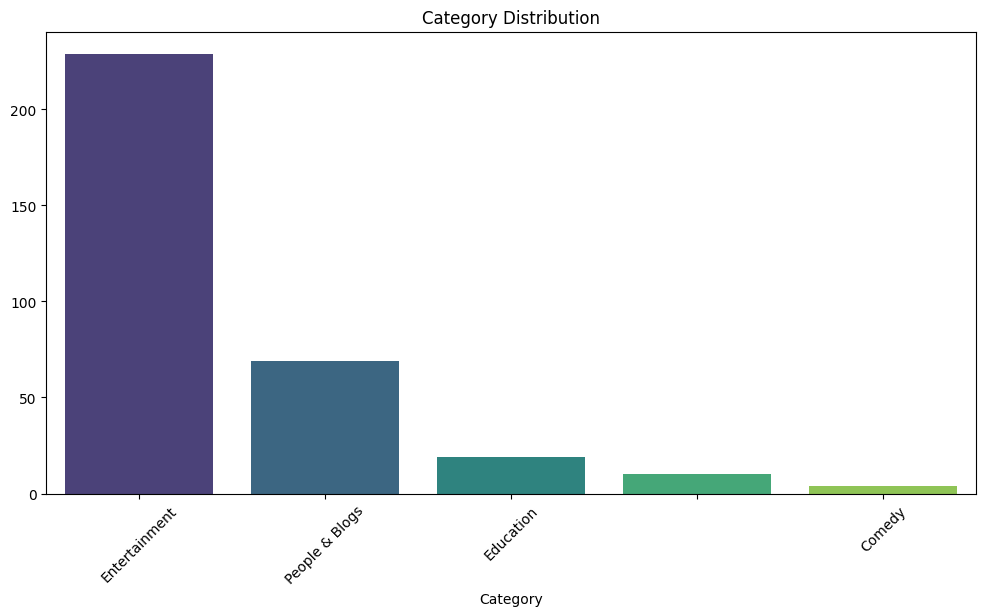

/var/folders/lp/5_kw6sqs1fv345yzdd0q9jcc0000gn/T/ipykernel_82593/2771210261.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dialogue_counts.index, y=dialogue_counts.values, palette="coolwarm")


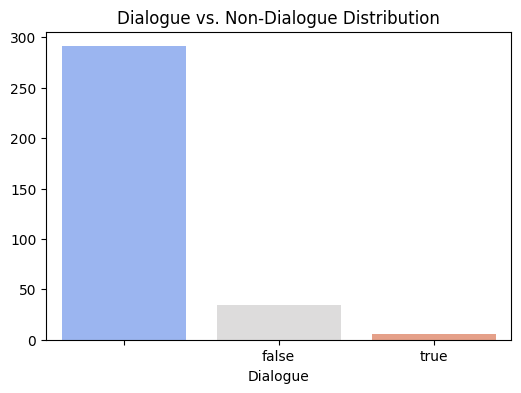


📍 NLP Analysis for Labelled Data After Pre Processing:
=== NLP ANALYSIS ===

📌 Word Count Statistics:
 count     331.000000
mean     2148.453172
std       746.519074
min        57.000000
25%      1657.000000
50%      1989.000000
75%      2452.500000
max      5698.000000
Name: Word Count, dtype: float64

📌 Lexical Diversity: 0.1166

📌 Percentage of Stopwords: 0.03 %

📌 Most Common Words:
 [('علي', 13125), ('ان', 9220), ('انا', 5810), ('دا', 4987), ('او', 4858), ('بقي', 4252), ('كانت', 2922), ('زي', 2564), ('انه', 2348), ('اي', 2294)]

📌 Most Common Bigrams:
 [(('صديقي', 'الانسان'), 1046), (('ان', 'انا'), 561), (('الولايات', 'المتحده'), 448), (('النهار', 'دا'), 403), (('سبحانه', 'وتعالي'), 336), (('قطاع', 'غزه'), 331), (('الاحتلال', 'الاسرائيلي'), 329), (('وفي', 'الوقت'), 312), (('كفايه', 'بقي'), 308), (('الله', 'سبحانه'), 292)]

📌 Most Common Trigrams:
 [(('الله', 'سبحانه', 'وتعالي'), 286), (('علي', 'سبيل', 'المثال'), 282), (('جديده', 'باذن', 'الله'), 230), (('حلقات', 'جديده', 'باذن'),

In [33]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def arabic_tokenizer(text):
    return tokenize.word_tokenize(text)

# Combine Arabic + English stopwords
ALL_STOPWORDS = set(stopwords.words("arabic") + stopwords.words("english"))

def analyze_channel_data(labelled_df):
    print("=== CHANNEL ANALYSIS ===")

    df = labelled_df.copy()
    df = df.dropna(subset=["Category"])
    df["Script Length"] = df["Processed Script"].apply(lambda x: len(arabic_tokenizer(x)))

    # Average Script length per channel
    avg_length = df.groupby("Channel")["Script Length"].mean()
    print("\n📌 Average Episode Length per Channel:\n", avg_length)

    # Number of episodes per channel
    episode_count = df.groupby("Channel")["Episode Title"].nunique()
    print("\n📌 Number of Episodes per Channel:\n", episode_count)

    # Most common category per channel
    modal_category = df.groupby("Channel")["Category"].agg(lambda x: x.value_counts().idxmax() if x.value_counts().size > 0 else "Unknown")
    print("\n📌 Most Common Category per Channel:\n", modal_category)

    # Plot category distribution
    plt.figure(figsize=(12, 6))
    category_distribution = df["Category"].value_counts()
    sns.barplot(x=category_distribution.index, y=category_distribution.values, palette="viridis")
    plt.xticks(rotation=45)
    plt.title("Category Distribution")
    plt.show()

    # Dialogue analysis
    if "Dialogue" in df.columns and df["Dialogue"].notna().sum() > 0:
        dialogue_counts = df["Dialogue"].dropna().value_counts()
        plt.figure(figsize=(6, 4))
        sns.barplot(x=dialogue_counts.index, y=dialogue_counts.values, palette="coolwarm")
        plt.title("Dialogue vs. Non-Dialogue Distribution")
        plt.show()

def analyze_nlp_statistics(labelled_df):
    print("=== NLP ANALYSIS ===")

    df = labelled_df.copy()
    df["Word Count"] = df["Processed Script"].apply(lambda x: len(arabic_tokenizer(x)))
    print("\n📌 Word Count Statistics:\n", df["Word Count"].describe())

    # Lexical diversity
    all_words = [word.lower() for sentence in df["Processed Script"] for word in arabic_tokenizer(sentence)]
    unique_words = set(all_words)
    lexical_diversity = len(unique_words) / len(all_words) if all_words else 0
    print("\n📌 Lexical Diversity:", round(lexical_diversity, 4))

    # Stopword ratio
    filtered_words = [word for word in all_words if word not in ALL_STOPWORDS]
    stopword_ratio = 1 - (len(filtered_words) / len(all_words)) if all_words else 0
    print("\n📌 Percentage of Stopwords:", round(stopword_ratio * 100, 2), "%")

    # Most common words
    common_words = Counter(filtered_words)
    print("\n📌 Most Common Words:\n", common_words.most_common(10))

    # Common bigrams and trigrams
    bigrams = list(ngrams(filtered_words, 2))
    trigrams = list(ngrams(filtered_words, 3))
    print("\n📌 Most Common Bigrams:\n", Counter(bigrams).most_common(10))
    print("\n📌 Most Common Trigrams:\n", Counter(trigrams).most_common(10))
    
print("📍 Analysis for Labelled Data After Pre Processing:")
analyze_channel_data(labelled_df)

print("\n📍 NLP Analysis for Labelled Data After Pre Processing:")
analyze_nlp_statistics(labelled_df)

# print("\n📍 Analysis for Unlabelled Data:")
# analyze_channel_data(unlabelled_df)

# print("\n📍 NLP Analysis for Unlabelled Data:")
# analyze_nlp_statistics(unlabelled_df)

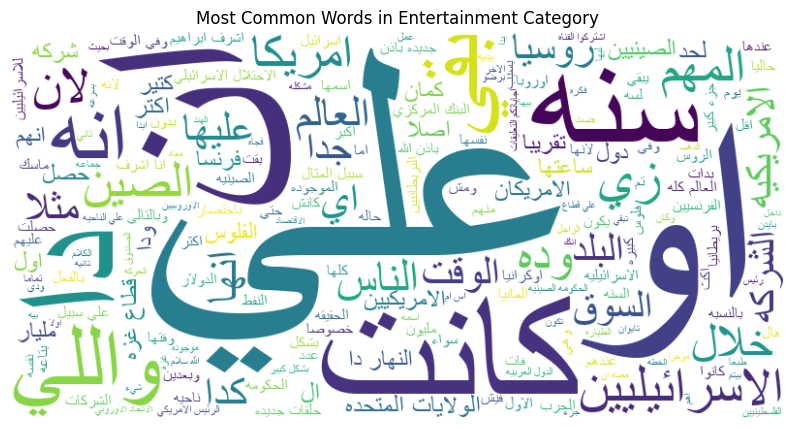

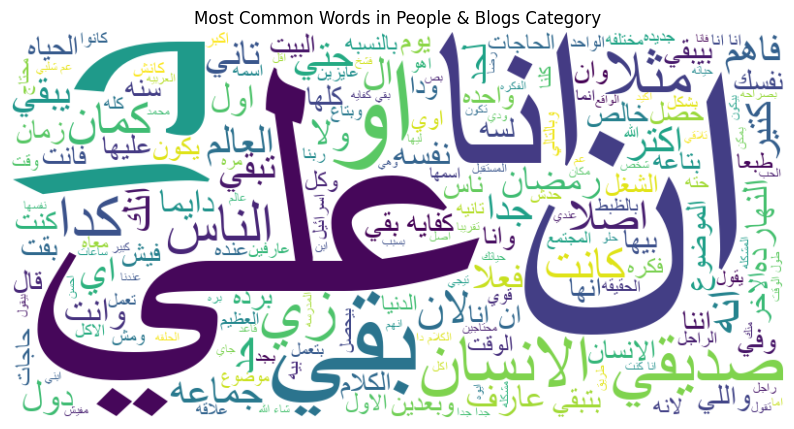

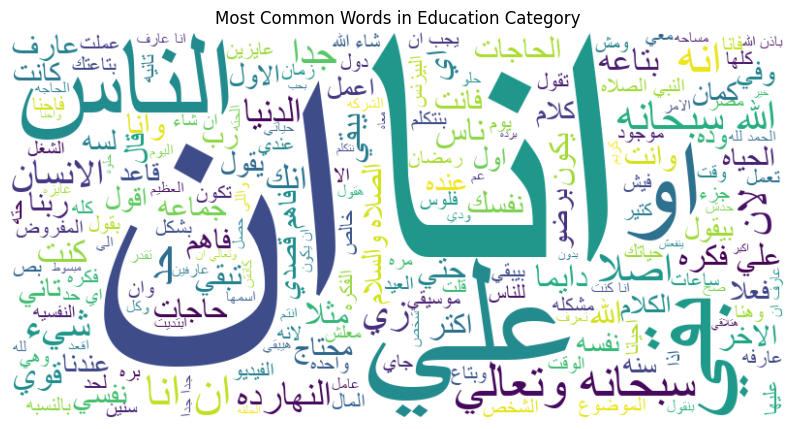

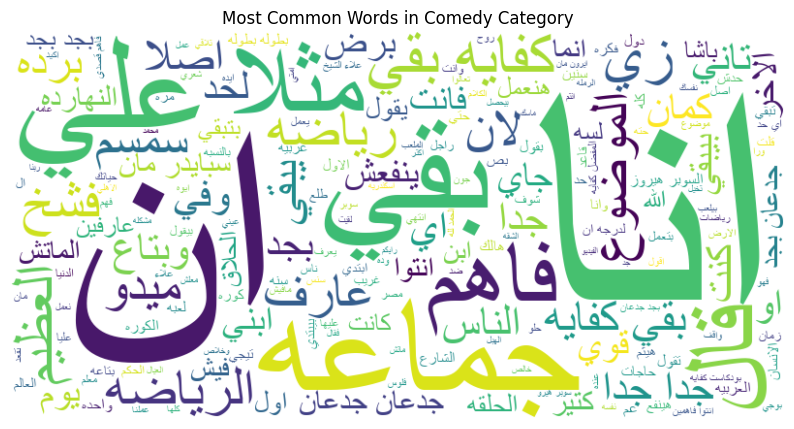

In [34]:
from wordcloud import WordCloud
import arabic_reshaper

def plot_wordcloud_for_category(df, category):
    category_df = df[df['Category'] == category]
    all_text = ' '.join(category_df['Processed Script'].values)
    all_text = arabic_reshaper.reshape(all_text)
    all_text = get_display(all_text)
    
    font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white', font_path=font_path).generate(all_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Most Common Words in {category} Category")
    plt.axis('off')
    plt.show()


plot_wordcloud_for_category(labelled_df, "Entertainment")
plot_wordcloud_for_category(labelled_df, "People & Blogs")
plot_wordcloud_for_category(labelled_df, "Education")
plot_wordcloud_for_category(labelled_df, "Comedy")


### 4. Analysis (On Proc) 1
	- Text Sampling
	- Text Visualizations

In [24]:
def sample_rows_per_channel(df, channel_column="Channel", num_samples=3):
    unique_channels = df[channel_column].unique()
    for channel in unique_channels:
        print(f"📌 Sample rows from channel: {channel}")
        display(df[df[channel_column] == channel].sample(min(num_samples, len(df[df[channel_column] == channel]))))
        print("-" * 80)

print("📍 Checking Unlabelled DataFrame:")
sample_rows_per_channel(unlabelled_df)

print("\n📍 Checking Labelled DataFrame:")
sample_rows_per_channel(labelled_df)


📍 Checking Unlabelled DataFrame:
📌 Sample rows from channel: Da7ee7


,Channel,Episode Title,Original Script,Processed Script,Category
7,Da7ee7,مانشستر يونايتد الدحيح,شباب، ممكن نهاجم؟ الماتش بيخلص!\nالماتش بيخلص!...,شبب مكن هجم اتش خلص اتش خلص هجم ضغط حمد ضغط ضغ...,
42,Da7ee7,ماذا قال الدحيح عن مقاييس الجمال و الأتيكيت؟ ...,[موسيقى]\n[موسيقى]\n[موسيقى]\nالاستاذ رمزي الم...,وسق وسق وسق ساذ رمز رشد خبر اتك هرد هنتكلم علي...,
126,Da7ee7,الموناليزا وحشة الدحيح,اهلا بكم في حلقه جديده من برنامجنا سيدتي\nالجم...,اهل حلق جدد رنمج سيد جمل نسب لكل كان لكل زمن م...,


--------------------------------------------------------------------------------
📌 Sample rows from channel: Elsaha


,Channel,Episode Title,Original Script,Processed Script,Category
174,Elsaha,ذكريات سالم إكسبريس.. حكاية حسام ناصف,[موسيقى]\nده بالنسبه لي الاقصى دي مش منافسات ا...,وسق ده نسب اقص دي مش نفس الل بحب ارح لغي دلق ن...,
147,Elsaha,نحلم ونسعى وبس.. حكاية آية عباس,من المواقف اللي في الرياضه نفسها اثرت\nفيا انا...,وقف الل ريض نفس اثر فيا انا سير انه انا فكر او...,
155,Elsaha,حلم العودة.. حكاية مدرس سوداني,انه اللحظه اللي انا كنت طالع من السودان\nفكانت...,انه لحظ الل انا كنت طلع سود فكن يعن دمع نزل كن...,


--------------------------------------------------------------------------------

📍 Checking Labelled DataFrame:
📌 Sample rows from channel: Kefaya Ba2a


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
13,Kefaya Ba2a,اتقلوا تاخدوا حاجة نضيفة!!!!!,[موسيقى]\nانت فكرنا فين\nالسيز احنا محتاجين ال...,وسق انت فكر فين سيز احن حتج كفي بجد ايه ولل بج...,false,Podcast,,People & Blogs
8,Kefaya Ba2a,بودكاست كفاية بقى - العقل السليم,[موسيقى]\nاهلا بكم في بودكاست كفايه بقى البودك...,وسق اهل دكس كفي بقي دكس ده جمع نسب صحب قلب ضعف...,false,Podcast,,Comedy
2,Kefaya Ba2a,بودكاست كفاية بقى - تشيز كيك بدون تشيز,اهلا بكم في بودكاست كفايه بقى البودكاست\nده يا...,اهل دكس كفي بقي دكس ده جمع نسب صحب قلب ضعف الل...,false,Podcast,,People & Blogs


--------------------------------------------------------------------------------
📌 Sample rows from channel: Business Bel Araby


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
26,Business Bel Araby,من الصفر الى اكبر مُصنع ومصدر لعربات البيع الم...,اهم حاجه بالنسبه لي ودايما دايما بقولها\nلاي ح...,اهم حجه نسب ودي داي بقل لاي حد يلز هرد رحت قعد...,,,,
22,Business Bel Araby,ما معنى النجاح #2,ايه معنى النجاح بالنسبه لك في الحياه\nعامه عار...,ايه عني نجح نسب حيه عمه عرف اولوياتك ان حد تني...,true,Podcast,,Education
24,Business Bel Araby,بناء المشروعات من البداية الى النجاح مع عمر اب...,لا هو رقم واحد في القاعده رقم واحد يعني\nالنفس...,رقم قعد رقم يعن نفس طول كسب صدق نفس انك انت اخ...,,,,


--------------------------------------------------------------------------------
📌 Sample rows from channel: B Hodoo2


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
27,B Hodoo2,إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق و...,انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...,انا هرد جاي قولل ازي تزد دخل ادي ازي يبق عند ف...,,,,
42,B Hodoo2,كيف وجدت الله _ الأوقات الصعبة (فضفضة مشاعر) ...,النهارده انا بهدي الحلقه دي لنفسي اولا\nوالله ...,هرد انا بهد حلق دي نفس اول ولل بجد لان بقل كلم...,false,Podcast,,Education
36,B Hodoo2,عقلية المال والسعادة _ بودكاست بهدوء مع كريم _...,السلام عليكم\nورحمه انت ازاي تدخل عليا بوكاس ك...,سلم علي رحم انت ازي دخل علا وكس كده انت عاك كا...,false,Podcast,,Education


--------------------------------------------------------------------------------
📌 Sample rows from channel: Fi_Al_Hadaraa


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
89,Fi_Al_Hadaraa,من_الجزائر_إلى_فيتنام_.._كيف_استفادت_المقاوم...,من سنتين تقريبًا، قِدِر الفلسطينيين\nإنهم يقاو...,سنت قرب قدر لسط نهم قوم حال هجر حي شيخ جرح قدس...,,Youtube,00:15:25,People & Blogs
66,Fi_Al_Hadaraa,إنما_الأمم_الأخلاق__في_الحضارة,أحلى قهوة هتشربوها في حياتكم.\nالله يرحمك يا أ...,احل قهه هتشربو حيت الل رحم اما كانت عمل فنج قه...,,Youtube,00:16:43,People & Blogs
65,Fi_Al_Hadaraa,تحية_للمكن__في_الحضارة,ماشي!\nماشي!\nلمّا أشوفهم على السلم، حاضر!\nيا...,اشي اشي اشف علي سلم حضر حاج حاج انت قعد سكت بق...,,Youtube,00:15:07,People & Blogs


--------------------------------------------------------------------------------
📌 Sample rows from channel: Al_Mokhbir_Al_Eqtisadi


,Channel,Episode Title,Original Script,Processed Script,Dialogue,Type,Length,Category
147,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي__كيف_تفهم_تحركات_أسعار_الذهب...,الناس اللي بتتناول فلوسها في الاسواق\nالماليه ...,ناس الل نول فلس سوق اله غرب اكد عرف عبر شهر ال...,,Youtube,00:16:15,Entertainment
138,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي__لماذا_قتلت_روسيا_اتفاقية_الح...,في الساعات الاولى من صباح يوم الاثنين 17\nيولي...,ساع اول يوم اثن 17 2023 قوت خصه بحر اوكرانيه ض...,,Youtube,00:17:01,Entertainment
241,Al_Mokhbir_Al_Eqtisadi,المخبر_الاقتصادي__كيف_تسيطر_الصين_على_قطاع_الا...,إيه هي علاقة الأدوية اللي بنبلبعها\nكل يوم بال...,ايه علق ادي الل لبع يوم صين اي دوا اخد خلل اخر...,,Youtube,00:16:00,Entertainment


--------------------------------------------------------------------------------


### 5. Data Preparation
	- Category selection? Handle Class Imbalance
	- Feature extraction (bag of words, TF-IDF, word embeddings / vectorization)
	- Encoding
	- Data splitting

In [212]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Category Selection and Class Imbalance Handling
print("Category distribution:")
category_counts = labelled_df['Category'].value_counts()
print(category_counts)

# Handling class imbalance options:
# a. Remove categories with very few samples (optional)
MIN_SAMPLES = 5
valid_categories = category_counts[category_counts >=
                                   MIN_SAMPLES].index.tolist()
filtered_df = labelled_df[labelled_df['Category'].isin(valid_categories)]

print(f"Original dataset size: {len(labelled_df)}")
print(f"Filtered dataset size: {len(filtered_df)}")

# 2. Feature Extraction
# Choose one of the following feature extraction methods:

# Option 1: Bag of Words
start_time = time.time()
count_vectorizer = CountVectorizer(min_df=2, max_df=0.95)
X_bow = count_vectorizer.fit_transform(filtered_df['Processed Script'])
bow_time = time.time() - start_time

# Option 2: TF-IDF (usually performs better for text classification)
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(filtered_df['Processed Script'])
tfidf_time = time.time() - start_time

# Let's use TF-IDF for our primary feature set
# as it generally outperformes Bag of Words
X = X_tfidf

print(f"Bag of Words computation time: {bow_time:.4f} seconds")
print(f"TF-IDF computation time: {tfidf_time:.4f} seconds")

# 3. Encoding the target variable (categories)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_df['Category'])

# Display the encoding mapping
category_mapping = dict(
    zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\nCategory encoding mapping:")
for category, code in category_mapping.items():
    print(f"{category} -> {code}")

# 4. Data Splitting
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Further handle class imbalance with SMOTE (only on training data)
print("\nClass distribution before SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(Counter(y_train_resampled))

# 6. Prepare a function to process and vectorize unlabelled data
def prepare_unlabelled_data(unlabelled_df, vectorizer):
    """Process and vectorize unlabelled data using the same vectorizer as the training data"""
    X_unlabelled = vectorizer.transform(unlabelled_df['Processed Script'])
    return X_unlabelled


# Process unlabelled data using the same vectorizer
X_unlabelled = prepare_unlabelled_data(unlabelled_df, tfidf_vectorizer)

print(f"\nTraining set shape: {X_train_resampled.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Unlabelled data shape: {X_unlabelled.shape}")

Category distribution:
Category
Entertainment     229
People & Blogs     66
Education          17
                   15
Comedy              4
Name: count, dtype: int64
Original dataset size: 331
Filtered dataset size: 327
Bag of Words computation time: 0.2653 seconds
TF-IDF computation time: 0.2775 seconds

Category encoding mapping:
 -> 0
Education -> 1
Entertainment -> 2
People & Blogs -> 3

Class distribution before SMOTE:
Counter({2: 183, 3: 53, 1: 13, 0: 12})

Class distribution after SMOTE:
Counter({2: 183, 3: 183, 1: 183, 0: 183})

Training set shape: (732, 9526)
Testing set shape: (66, 9526)
Unlabelled data shape: (193, 9526)


/Users/shady/Documents/Personal/GUC/Semester 10/NLP/NLP-project/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
